 ### Introduction to Data Science - 2019.2

 ### Valter Moreno

 ### Homework 2: Predicting Schools Performance

 ### Data

 The data for this project was provided in four csv files containing information on shools in São Paulo metropolitan region. They included characteristics of the students and classes, academic perfomance metrics, and results in the national evaluation exam (ENEM).

In [41]:
import numpy as np
import pandas as pd
import seaborn as sb

pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [42]:
# Reading the data into dataframes

enem = pd.read_csv('Data/ENEM2015.csv', header=0, names=['CD_ESCOLA','PARTICIPANTES','ENEM'], encoding='utf-8')
rendimento = pd.read_csv('Data/RendimentoEscolar2000-2015.csv', encoding='utf-8')
escolas = pd.read_csv('Data/DadosEscolares1996-2015.csv', encoding='utf-8')

censo = pd.read_csv('Data/ESC2013_RMSP_CEM.csv', encoding='utf-8')
censo.replace(['999,9', '999,99', '9999,99'], '', inplace=True)


In [43]:
enem.head()


,CD_ESCOLA,PARTICIPANTES,ENEM
0,35000139,142,1
1,35000140,79,1
2,35000267,131,2
3,35000280,146,1
4,35000334,95,1


In [44]:
enem.dtypes


CD_ESCOLA        int64
PARTICIPANTES    int64
ENEM             int64
dtype: object

In [45]:
censo.head()


,ID,LONGITUDE,LATITUDE,CODESC,CODESCTX,NOMEESC,NOMEMUN,CODMUN,NOMDIST,CODDIST,...,IDEB11AF,IDEB13AF,RED_EN13,LC_EN13,MAT_EN13,CH_EN13,CN_EN13,ENEM2013,INSE_AB,INSE_CL
0,90,-47143986,-23986886,35080548,35080548,BAIRRO DOS BARNABES RECANTO DAS ORQUIDEAS,JUQUITIBA,3526209,BARNABES,352620910.00,...,nan,nan,nan,nan,nan,nan,nan,nan,50.69,Medio Alto
1,398,-47145545,-23985717,35352524,35352524,MARIA CRISTINA BRESSALI CHAMA CRECHE MUNICIPAL,JUQUITIBA,3526209,BARNABES,352620910.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN
2,399,-47145560,-23985685,35069929,35069929,TERRA NOVA EM,JUQUITIBA,3526209,BARNABES,352620910.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN
3,400,-47146239,-23983873,35036365,35036365,BAIRRO DOS BARNABES,JUQUITIBA,3526209,BARNABES,352620910.00,...,4.50,4.40,nan,nan,nan,nan,nan,nan,47.33,Medio
4,97,-47141337,-23964408,35913424,35913424,BAIRRO DAS SENHORINHAS,JUQUITIBA,3526209,BARNABES,352620910.00,...,4.70,4.40,451.33,469.34,480.52,485.11,444.71,469.92,49.38,Medio


In [47]:
print('Columns of the string type:')
print(list(censo.select_dtypes('object').columns))
print()
print('Columns of numeric type:')
print(list(censo.select_dtypes('number').columns))

Columns of the string type:
[u'NOMEESC', u'NOMEMUN', u'NOMDIST', u'TIP_DEP', u'BAIRRO', u'END_ESC', u'NUM_ESC', u'DDD', u'TELEFONE', u'INSE_CL']
()
Columns of numeric type:
[u'ID', u'LONGITUDE', u'LATITUDE', u'CODESC', u'CODESCTX', u'CODMUN', u'CODDIST', u'COD_SC', u'COD_DEP', u'CEP', u'LOCALIZA', u'LAB_INF', u'QD_ESP_C', u'QD_ESP_D', u'BIBLIO', u'ENS_REG', u'REG_IN_CR', u'REG_IN_PE', u'REG_FU_8A', u'REG_FU_9A', u'REG_MED', u'REG_MED_I', u'REG_MED_N', u'REG_MED_P', u'ENS_ESP', u'ESP_IN_CR', u'ESP_IN_PE', u'ESP_FU_8A', u'ESP_FU_9A', u'ESP_MED', u'ESP_MED_I', u'ESP_MED_N', u'ESP_MED_P', u'ESP_EJA_F', u'ESP_EJA_M', u'EJA', u'EJA_FUND', u'EJA_MED', u'EJA_PROJ', u'AP5EF_07', u'AP9EF_07', u'AP3EM_07', u'AB1EM_07', u'AP5EF_08', u'AP9EF_08', u'AP3EM_08', u'AB1EM_08', u'AP5EF_09', u'AP9EF_09', u'AP3EM_09', u'AB1EM_09', u'AP5EF_10', u'AP9EF_10', u'AP3EM_10', u'AB1EM_10', u'AP5EF_11', u'AP9EF_11', u'APR3EM_11', u'AB1EM_11', u'AP5EF_12', u'AP9EF_12', u'AP3EM_12', u'AB1EM_12', u'AP5EF_13', u'AP9EF_

In [48]:
rendimento.head()


,CODMEC,ANO,DEP,NOME,SETEDU,DISTRITO,SUBPREF,DIRET,ZONA,EFABAND9ANOS1S,...,EPABAND,EJAIABAND,EJAIAPROV,EJAIREPROV,EJAITOTAL,EJAIIABAND,EJAIIAPROV,EJAIIREPROV,EJAIITOTAL,"EJATOTAL,,"
0,35053107,2014,MUNICIPAL,"MILTOM CAMPOS, SEN.",1105,BRASILANDIA,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,3,...,0,20,9,10,39,37,65,31,133,"172,"
1,35053119,2014,MUNICIPAL,THEO DUTRA,1107,BRASILANDIA,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,0,...,0,0,0,0,0,1,103,59,163,"163,,"
2,35053120,2014,MUNICIPAL,PLINIO AYROSA,2906,FREGUESIA DO O,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,5,...,0,0,0,0,0,29,65,26,120,"120,,"
3,35053132,2014,MUNICIPAL,BRASIL-JAPAO,6703,RIO PEQUENO,BUTANTA,BUTANTA,OESTE,1,...,0,30,16,13,59,26,110,122,258,"317,,"
4,35053144,2014,MUNICIPAL,"AMORIM LIMA, DES.",1201,BUTANTA,BUTANTA,BUTANTA,OESTE,1,...,0,0,0,0,0,0,0,0,0,"0,"


In [49]:
print('Columns of the string type:')
print(list(rendimento.select_dtypes('object').columns))
print()
print('Columns of numeric type:')
print(list(rendimento.select_dtypes('number').columns))


Columns of the string type:
[u'DEP', u'NOME', u'SETEDU', u'DISTRITO', u'SUBPREF', u'DIRET', u'ZONA', u'EJATOTAL,,']
()
Columns of numeric type:
[u'CODMEC', u'ANO', u'EFABAND9ANOS1S', u'EFABAND9ANOS2S', u'EFABAND9ANOS3S', u'EFABAND9ANOS4S', u'EFABAND9ANOS5S', u'EFABAND9ANOS6S', u'EFABAND9ANOS7S', u'EFABAND9ANOS8S', u'EFABAND9ANOS9S', u'EFABAND1S', u'EFABAND2S', u'EFABAND3S', u'EFABAND4S', u'EFABAND5S', u'EFABAND6S', u'EFABAND7S', u'EFABAND8S', u'TOTALEF_ABAND', u'EFAPROV9ANOS1S', u'EFAPROV9ANOS2S', u'EFAPROV9ANOS3S', u'EFAPROV9ANOS4S', u'EFAPROV9ANOS5S', u'EFAPROV9ANOS6S', u'EFAPROV9ANOS7S', u'EFAPROV9ANOS8S', u'EFAPROV9ANOS9S', u'EFAPROV1S', u'EFAPROV2S', u'EFAPROV3S', u'EFAPROV4S', u'EFAPROV5S', u'EFAPROV6S', u'EFAPROV7S', u'EFAPROV8S', u'TOTALEF_APROV', u'EFREPROV9ANOS1S', u'EFREPROV9ANOS2S', u'EFREPROV9ANOS3S', u'EFREPROV9ANOS4S', u'EFREPROV9ANOS5S', u'EFREPROV9ANOS6S', u'EFREPROV9ANOS7S', u'EFREPROV9ANOS8S', u'EFREPROV9ANOS9S', u'EFREPROV1S', u'EFREPROV2S', u'EFREPROV3S', u'EFREPRO

 The last column of the dataframe is ill-formatted.
 Its contents will be fixed and stored as integers.

In [50]:
cols = list(rendimento.columns)
del cols[-1]
cols.append('EJATOT')
rendimento.columns = cols
rendimento.EJATOT = pd.to_numeric(rendimento.EJATOT.str.replace(',', ''))

rendimento.head()


,CODMEC,ANO,DEP,NOME,SETEDU,DISTRITO,SUBPREF,DIRET,ZONA,EFABAND9ANOS1S,...,EPABAND,EJAIABAND,EJAIAPROV,EJAIREPROV,EJAITOTAL,EJAIIABAND,EJAIIAPROV,EJAIIREPROV,EJAIITOTAL,EJATOT
0,35053107,2014,MUNICIPAL,"MILTOM CAMPOS, SEN.",1105,BRASILANDIA,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,3,...,0,20,9,10,39,37,65,31,133,172
1,35053119,2014,MUNICIPAL,THEO DUTRA,1107,BRASILANDIA,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,0,...,0,0,0,0,0,1,103,59,163,163
2,35053120,2014,MUNICIPAL,PLINIO AYROSA,2906,FREGUESIA DO O,FREGUESIA/BRASILANDIA,FREGUESIA/BRASILANDIA,NORTE,5,...,0,0,0,0,0,29,65,26,120,120
3,35053132,2014,MUNICIPAL,BRASIL-JAPAO,6703,RIO PEQUENO,BUTANTA,BUTANTA,OESTE,1,...,0,30,16,13,59,26,110,122,258,317
4,35053144,2014,MUNICIPAL,"AMORIM LIMA, DES.",1201,BUTANTA,BUTANTA,BUTANTA,OESTE,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
escolas.head()


,CODMEC,CODEOL,ANO,TIPOESC,NOME,DEP,DEPADM,SITUAÇÃO,MAIS EDUCAÇÃO,Qtde_Docentes,...,TOT_EE,TIPO_EE,EE_Creche,EE_Pre,EE_Fund,EE_Med,EE_EJA,EE_EP,ALEDESP,TOTAL_ALUNOS
0,35191292,306602.00,2005,PARINF,FIFO ESCOLA DE EDUCACAO INFANTIL,Privada,Privada,nan,NaN,nan,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,6
1,35055347,95401.00,2004,EMEF,"PRUDENTE DE MORAIS, PRES. ,EMEF",Municipal,PÃºblica,nan,NaN,nan,...,6.00,ClasseComum,nan,nan,nan,nan,nan,nan,0.00,1272
2,35199321,307534.00,2012,PARINF,ALPHA LESTE EEI,privada,particular,nan,NaN,3.00,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,22
3,35199254,307504.00,2012,PARINF,ESC PART BRILHO DO SOL,privada,particular,nan,NaN,5.00,...,1.00,ClasseComum,nan,nan,nan,nan,nan,nan,nan,56
4,35434541,307436.00,2012,PARINF,FREITAS MIGUEL ESCOLA DE EDUCACAO INFANTIL,privada,particular,nan,NaN,4.00,...,nan,NaN,nan,nan,nan,nan,nan,nan,nan,52


In [52]:
print('Columns of the string type:')
print(list(escolas.select_dtypes('object').columns))
print()
print('Columns of numeric type:')
print(list(escolas.select_dtypes('number').columns))


Columns of the string type:
[u'TIPOESC', u'NOME', u'DEP', u'DEPADM', u'MAIS EDUCA\xc7\xc3O', u'MERENDA', u'DISTRITO', u'SUBPREF', u'CORED', u'ZONA', u'DTURNOS - EMEF', u'T2D3D - EMEF', u'DTURNOS-EMEI', u'T2D3D - EMEI', u'TIPOENSEJA', u'TIPO_EE']
()
Columns of numeric type:
[u'CODMEC', u'CODEOL', u'ANO', u'SITUA\xc7\xc3O', u'Qtde_Docentes', u'NUM_FUNC', u'SETEDU', u'CL_CRECHE', u'CL_PRE', u'AL_CRECHE', u'AL_PRE', u'0', u'1', u'2', u'MENOR3', u'3', u'4', u'5', u'6', u'6fund', u'0A3', u'0A4', u'4A6', u'5A6', u'>6', u'TotalEdInf', u'CLEM1S', u'CLEM2S', u'CLEM3S', u'CLEM4S', u'CLEMMU', u'ALEM1S', u'ALEM2S', u'ALEM3S', u'ALEM4S', u'ALEMMU', u'CLEM', u'ALEM', u'CLEF1S', u'CLEF2S', u'CLEF3S', u'CLEF4S', u'CLEF5S', u'CLEF6S', u'CLEF7S', u'CLEF8S', u'CLEFMU', u'ALEF1S', u'ALEF2S', u'ALEF3S', u'ALEF4S', u'ALEF5S', u'ALEF6S', u'ALEF7S', u'ALEF8S', u'ALEFMU', u'ALEFAC', u'CLEF1A4', u'CLEF5A8', u'CLEF1A8', u'ALEF1A4', u'ALEF5A8', u'ALEF1A8', u'CLE9F1S', u'CLE9F2S', u'CLE9F3S', u'CLE9F4S', u'CLE9F5S'

 ### Checking if the number of schools match in all files

In [53]:
cd_enem = enem.CD_ESCOLA.unique()
cd_censo = censo.CODESC.unique()
cd_rendimento = rendimento.CODMEC.unique()
cd_escolas = escolas.CODMEC.unique()

print('Number of records in each dataframe:')
print('cd_enem:', len(cd_enem))
print('cd_censo:', len(cd_censo))
print('cd_rendimento:', len(cd_rendimento))
print('cd_escolas:', len(cd_escolas), '\n')

print('Number of schools in the ENEM dataframe:')
print('cd_enem:', len(cd_enem))
print('cd_censo:', np.in1d(cd_censo, cd_enem).sum())
print('cd_rendimento:', np.in1d(cd_rendimento, cd_enem).sum())
print('cd_escolas:', np.in1d(cd_escolas, cd_enem).sum())


Number of records in each dataframe:
('cd_enem:', 1243)
('cd_censo:', 10937)
('cd_rendimento:', 4892)
('cd_escolas:', 9642, '\n')
Number of schools in the ENEM dataframe:
('cd_enem:', 1243)
('cd_censo:', 1243)
('cd_rendimento:', 505)
('cd_escolas:', 693)


 Many of the schools that are in the ENEM2015.csv file are not in
 in the other datasets. Schools that are not in the ENEM file
 will be dropped then from the other dataframes. Only schools that
 are listed in the four dataframes will be used in the analysis.

In [54]:
cd_enem = set(cd_enem)
cd_censo = set(cd_censo)
cd_rendimento = set(cd_rendimento)
cd_escolas = set(cd_escolas)

cods = cd_enem.intersection(cd_censo, cd_rendimento, cd_escolas)

enem = enem[enem.CD_ESCOLA.isin(cods)]
censo = censo[censo.CODESC.isin(cods)]
rendimento = rendimento[rendimento.CODMEC.isin(cods)]
escolas = escolas[escolas.CODMEC.isin(cods)]


 Dataframes 'rendimento' and 'escolas' contain longitudinal data.
 I will get the number of schools for which there is data for each
 year in the time horizon.

In [55]:
def long_count(df, df_name):
      print('Dataframe:', df_name)
      for year in np.sort(df.ANO.unique()):
            print(year, ': ',
                  df[(df.ANO == year) & (df.CODMEC.isin(cods))].shape[0])
      print('\n')

long_count(rendimento, 'Rendimento')
long_count(escolas, 'Escolas')


('Dataframe:', 'Rendimento')
(2000, ': ', 5)
(2001, ': ', 5)
(2002, ': ', 5)
(2003, ': ', 5)
(2004, ': ', 5)
(2005, ': ', 5)
(2006, ': ', 5)
(2007, ': ', 5)
(2008, ': ', 5)
(2009, ': ', 5)
(2010, ': ', 5)
(2011, ': ', 5)
(2012, ': ', 5)
(2013, ': ', 5)
(2014, ': ', 5)
(2015, ': ', 505)


('Dataframe:', 'Escolas')
(1996, ': ', 334)
(1997, ': ', 366)
(1998, ': ', 383)
(1999, ': ', 407)
(2000, ': ', 424)
(2001, ': ', 433)
(2002, ': ', 445)
(2003, ': ', 458)
(2004, ': ', 467)
(2005, ': ', 472)
(2006, ': ', 479)
(2007, ': ', 481)
(2008, ': ', 485)
(2009, ': ', 490)
(2010, ': ', 494)
(2011, ': ', 498)
(2012, ': ', 503)
(2013, ': ', 505)
(2014, ': ', 505)
(2015, ': ', 505)




 I decided to retain years for which there is data for at least 500 schools. This is
 necessary to allow meus to train and test the model with samples of reasonable size.
 Thus, I will be able to keep only the records for 2015 in 'rendimentos', and for
 2012, 2013, 2014 and 2015 in 'escolas'.

In [56]:

rendimento = rendimento[(rendimento.ANO == 2015) & 
                        (rendimento.CODMEC.isin(cods))]

rendimento[(rendimento.ANO == 2015) & (rendimento.CODMEC.isin(cods))].shape

escolas = escolas[(escolas.ANO.isin([2012, 2013, 2014, 2015])) &
                  (escolas.CODMEC.isin(cods))]

print('Number of remaining records in each dataframe:')
print('Enem:', enem.shape[0])
print('Censo:', censo.shape[0])
print('Rendimento:', rendimento.shape[0])
print('Escolas:', escolas.shape[0], '\n')

censo.to_csv('Data/censo.csv', index=False, encoding='utf-8')
rendimento.to_csv('Data/rendimento.csv', index=False, encoding='utf-8')
escolas.to_csv('Data/escolas.csv', index=False, encoding='utf-8')


Number of remaining records in each dataframe:
('Enem:', 505)
('Censo:', 505)
('Rendimento:', 505)
('Escolas:', 2018, '\n')


 ## Missing values
 I will performa a quick inspection of the dataframes for missing values.

In [57]:

def miss_data(df):
    cols = []
    values = []
    for col in df.columns:
        miss = df[col].isnull().sum()
        if miss > 0:
            cols.append(col)
            values.append(miss)
    missing = {'Columns': cols, 'Missing': values}
    return missing 


In [58]:
censo_miss = pd.DataFrame(miss_data(censo))
censo_miss['Percent missing'] = censo_miss.Missing/censo.shape[0]
print('Columns with missing values in dataframe Censo:', '\n',
      censo_miss.sort_values(by='Missing', ascending=False))


('Columns with missing values in dataframe Censo:', '\n',       Columns  Missing  Percent missing
0      COD_SC      505             1.00
62   IDEB13AI      505             1.00
57    NP13_AI      505             1.00
56    LP13_AI      505             1.00
55   MAT13_AI      505             1.00
43   MAT05_AI      501             0.99
58   IDEB05AI      501             0.99
44    LP05_AI      501             0.99
45    NP05_AI      501             0.99
50    LP09_AI      500             0.99
68    NP07_AF      500             0.99
48    NP07_AI      500             0.99
47    LP07_AI      500             0.99
46   MAT07_AI      500             0.99
52   MAT11_AI      500             0.99
53    LP11_AI      500             0.99
54    NP11_AI      500             0.99
59   IDEB07AI      500             0.99
60   IDEB09AI      500             0.99
61   IDEB11AI      500             0.99
63   MAT05_AF      500             0.99
51    NP09_AI      500             0.99
65    NP05_AF      500

In [59]:
rendimento_miss = pd.DataFrame(miss_data(rendimento))
rendimento_miss['Percent missing'] = rendimento_miss.Missing/rendimento.shape[0]
print('Columns with missing values in dataframe Rendimento:', '\n',
      rendimento_miss.sort_values(by='Missing', ascending=False))


('Columns with missing values in dataframe Rendimento:', '\n', Empty DataFrame
Columns: [Columns, Missing, Percent missing]
Index: [])


In [60]:
escolas_miss = pd.DataFrame(miss_data(escolas))
escolas_miss['Percent missing'] = escolas_miss.Missing/escolas.shape[0]
print('Columns with missing values in dataframe Escolas:', '\n',
      escolas_miss.sort_values(by='Missing',ascending=False))


('Columns with missing values in dataframe Escolas:', '\n',                 Columns  Missing  Percent missing
11         T2D3D - EMEI     2018             1.00
10         DTURNOS-EMEI     2018             1.00
3         MAIS EDUCAÇÃO     2015             1.00
6               MERENDA     2013             1.00
8        DTURNOS - EMEF     2008             1.00
0                CODEOL     1996             0.99
1                DEPADM     1515             0.75
2              SITUAÇÃO     1513             0.75
9          T2D3D - EMEF     1498             0.74
191   EE_INTELECTUAL_EP     1362             0.67
172  EE_INTELECTUAL_EJA     1352             0.67
134  EE_INTELECTUAL_CRE     1351             0.67
59               ALEFMU     1342             0.67
107        ALES1A4_SEMI     1342             0.67
60               ALEFAC     1342             0.67
86              ALE9FMU     1342             0.67
50               CLEFMU     1342             0.67
111       ALESMED_EXAME     1342        

In [61]:
censo_miss.to_csv('Data/censo_miss.csv', index=False, encoding='utf-8')
rendimento_miss.to_csv('Data/rendimento_miss.csv', index=False, encoding='utf-8')
escolas_miss.to_csv('Data/escolas_miss.csv', index=False, encoding='utf-8')


 Alghough the 'rendimento' dataframe has no missing values, 'censo' and
 'escolas' do.
 Instead of inputing the missing values, I will drop the records with missing
 values for any of the features. Nevertheless, given the small size of the sample
 (505 schools), I want to retain as much data as possible.
 I start by discarding columns with more than 10% of missing data. Before,
 I do this, I will merge the 'enem', 'censo', and 'rendimento' dataframes, as
 they have data only for one year. Because the 'escolas' dataframe has longitudinal data,
 it will be treated separetely.

In [62]:
schools = enem.merge(censo, left_on = 'CD_ESCOLA', right_on='CODESC')
schools = schools.merge(rendimento, left_on = 'CD_ESCOLA', right_on='CODMEC')
schools.drop(['CODESC', 'CODMEC', 'ANO', 'DEP', 'NOME', 'SETEDU',
              'DISTRITO', 'SUBPREF', 'DIRET', 'ZONA',],
             axis=1, inplace=True)


In [63]:
def drop_miss(df, df_miss, percent):
      drop_cols = df_miss[df_miss['Percent missing'] >= percent].Columns
      df.drop(drop_cols, axis=1, inplace=True)
      return df


In [64]:
schools_miss = pd.DataFrame(miss_data(schools))
schools_miss['Percent missing'] = schools_miss.Missing/schools.shape[0]

schools = drop_miss(schools, schools_miss, .10)


In [65]:
escolas = escolas[escolas.CODMEC.isin(schools.CD_ESCOLA)]

escolas_miss = pd.DataFrame(miss_data(escolas))
escolas_miss['Percent missing'] = escolas_miss.Missing/escolas.shape[0]
escolas = drop_miss(escolas, escolas_miss, .10)


 Here are the remaining columns with missing values:

In [66]:
schools_miss = pd.DataFrame(miss_data(schools))
schools_miss['Percent missing'] = schools_miss.Missing/schools.shape[0]
print('Columns with missing values in dataframe Schools:', '\n',
      schools_miss.sort_values(by='Missing', ascending=False))
print()
print('Sorted by name:', '\n',
      schools_miss.sort_values(by='Columns'))


('Columns with missing values in dataframe Schools:', '\n',       Columns  Missing  Percent missing
2    AP9EF_09       49             0.10
4    AB1EM_10       43             0.09
6   APR3EM_11       41             0.08
5    AP9EF_11       39             0.08
3    AP9EF_10       38             0.08
9    AP3EM_12       36             0.07
17    INSE_AB       32             0.06
18    INSE_CL       32             0.06
8    AP9EF_12       28             0.06
11   AP9EF_13       26             0.05
7    AB1EM_11       26             0.05
14   AP9EF_14       25             0.05
12   AP3EM_13       20             0.04
10   AB1EM_12       13             0.03
15   AP3EM_14       13             0.03
1    TELEFONE       11             0.02
0         DDD       11             0.02
13   AB1EM_13        3             0.01
16   AB1EM_14        2             0.00)
()
('Sorted by name:', '\n',       Columns  Missing  Percent missing
4    AB1EM_10       43             0.09
7    AB1EM_11       26        

In [67]:
escolas_miss = pd.DataFrame(miss_data(escolas))
escolas_miss['Percent missing'] = escolas_miss.Missing/escolas.shape[0]
print('Columns with missing values in dataframe Escolas:', '\n',
      escolas_miss.sort_values(by='Missing', ascending=False))
print()
print('Sorted by name:', '\n',
      escolas_miss.sort_values(by='Columns'))


('Columns with missing values in dataframe Escolas:', '\n',        Columns  Missing  Percent missing
2          0A3      201             0.10
3          0A4      201             0.10
4          4A6      201             0.10
5          5A6      201             0.10
6           >6      201             0.10
7   TotalEdInf      201             0.10
1       MENOR3      201             0.10
18     CLE9F1S      167             0.08
27     ALE9F1S      167             0.08
19     CLE9F2S      147             0.07
28     ALE9F2S      147             0.07
22     CLE9F5S      143             0.07
31     ALE9F5S      143             0.07
20     CLE9F3S      141             0.07
29     ALE9F3S      140             0.07
21     CLE9F4S      137             0.07
30     ALE9F4S      137             0.07
26     CLE9F9S      131             0.06
35     ALE9F9S      131             0.06
34     ALE9F8S      112             0.06
25     CLE9F8S      112             0.06
23     CLE9F6S       94             0.

 Based on the descriptions of the variables in the data dictionary,
 features that seem less relevant to predict the school's result
 in ENEM and that have missing values will be removed from the
 dataframes.

 The following columns will be dropped from the 'schools' dataframe:
     - AP9EF_09
     - AB1EM_10
     - APR3EM_11
     - AP9EF_11
     - AP9EF_10
     - AP3EM_12

In [68]:
schools.drop(['AP9EF_09', 'AB1EM_10', 'APR3EM_11',
              'AP9EF_11', 'AP9EF_10', 'AP3EM_12'],
             axis =1, inplace=True)


 The following columns will be dropped from the 'escolas' dataframe:
     - 0A3
     - 0A4
     - 4A6
     - 5A6
     - >6
     - TotalEdInf
     - MENOR3
     - CLE9F1S
     - ALE9F1S
     - CLE9F2S
     - ALE9F2S
     - CLE9F5S
     - ALE9F5S
     - CLE9F3S
     - ALE9F3S
     - CLE9F4S
     - ALE9F4S
     - CLE9F9S
     - ALE9F9S
     - ALE9F8S
     - CLE9F8S
     - CLE9F6S
     - ALE9F6S
     - CLE9F7S
     - ALE9F7S

In [69]:
escolas.drop(escolas_miss[escolas_miss['Percent missing'] > 0.01]['Columns'], 
             axis=1, inplace=True)


 The 'escolas' dataframe is in the long format. It will be converted to the
 wide format before the rows with missing values are removed.

In [70]:
escolas.drop(['TIPOESC', 'NOME', 'DEP', 'SETEDU', 'DISTRITO',
              'SUBPREF', 'CORED', 'ZONA'], axis=1, inplace=True)

escolas_long = pd.melt(escolas, id_vars=['CODMEC','ANO'], 
                       var_name='Vars', value_name='Values')

escolas_long['NewVar'] = escolas_long['Vars'] + '_' + escolas_long['ANO'].map(str)
      
escolas_long.drop(['ANO', 'Vars'], axis=1, inplace=True)

escolas = escolas_long.pivot(index='CODMEC', columns='NewVar',
                             values='Values').reset_index()


 I will remove rows with missing values from both dataframes, and
 merge them into a new 'schools' dataframe. The new dataframe will be recorded
 to the 'Schools.csv' file.

In [71]:
schools.dropna(inplace=True)
escolas.dropna(inplace=True)

schools = schools.merge(escolas, left_on='CD_ESCOLA', right_on='CODMEC')
schools.head()


,CD_ESCOLA,PARTICIPANTES,ENEM,ID,LONGITUDE,LATITUDE,CODESCTX,NOMEESC,NOMEMUN,CODMUN,...,CLFUNDI_2014,CLFUNDI_2015,CLFUND_2012,CLFUND_2013,CLFUND_2014,CLFUND_2015,TOTAL_ALUNOS_2012,TOTAL_ALUNOS_2013,TOTAL_ALUNOS_2014,TOTAL_ALUNOS_2015
0,35054082,51,1,1895,-46693981,-23635637,35054082,EMEFM LINNEU PRESTES PROF,SAO PAULO,3550308,...,6.00,6.00,22.00,18.00,16.00,15.00,1171.00,1077.00,1061.00,1205.00
1,35060574,34,2,6515,-46570860,-23537896,35060574,CONDE DOMINGOS COLEGIO,SAO PAULO,3550308,...,8.00,8.00,15.00,16.00,14.00,14.00,434.00,405.00,442.00,435.00
2,35070178,135,2,6214,-46626384,-23513072,35070178,EMEFM DERVILLE ALLEGRETTI PROF,SAO PAULO,3550308,...,10.00,10.00,21.00,20.00,18.00,17.00,2051.00,1955.00,1887.00,1667.00
3,35071936,47,2,3304,-46725433,-23482531,35071936,CANELLO MARQUES COLEGIO,SAO PAULO,3550308,...,18.00,22.00,31.00,34.00,34.00,35.00,954.00,916.00,938.00,890.00
4,35100031,34,2,3001,-46728809,-23494505,35100031,SAO JOAO GUALBERTO COLEGIO,SAO PAULO,3550308,...,17.00,16.00,28.00,30.00,29.00,29.00,900.00,943.00,993.00,960.00


 The final dataset contains data for 436 schools.
 I will now drop columns that are not relevant to the analysis
 and set the type of categorical features to string.

In [72]:
schools.drop(['ID', 'LONGITUDE', 'LATITUDE', 'CODESCTX', 'NOMEESC',
              'NOMEMUN', 'NOMDIST', 'COD_DEP',
              'TIP_DEP', 'BAIRRO', 'CEP', 'END_ESC', 'NUM_ESC',
              'DDD', 'TELEFONE', 'LOCALIZA'], 
             axis=1, inplace=True)


In [73]:
schools.CD_ESCOLA = [str(x) for x in schools.CD_ESCOLA]
schools.CODMUN = [str(x) for x in schools.CODMUN]
schools.CODDIST = [str(int(x)) for x in schools.CODDIST]


 The next step is to check the feature for redundant information. To do this
 I will generate the correlations between variables and print them in a
 heatmap.

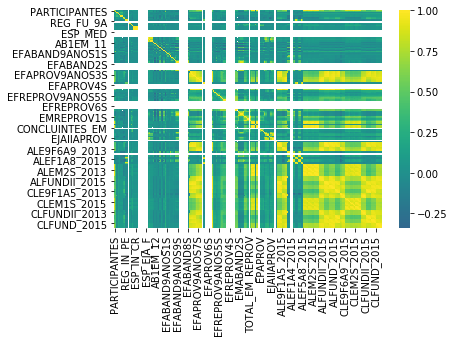

In [74]:
sb.heatmap(schools.corr(), cmap='viridis', center=0)


 The chart shows several variables with very high absolute correlations,
 suggesting the information they contain is redundant. I will list the
 variables with correlations equal to 1.0 or -1.0.

In [75]:

corr_1 = schools.select_dtypes('number').corr()

col_list = []

for col in corr_1.columns:
      if (sum(corr_1[col] == 1.0) >= 2) | (sum(corr_1[col] == -1.0) >= 1):
            col_list.append(col)

corr_1 = schools[col_list].corr()
corr_1


,ENS_ESP,ESP_IN_CR,ESP_IN_PE,EFAPROV2S,ALE9F1A5_2013,ALE9F1A5_2014,ALE9F1A5_2015,ALEF1A8_2013,ALEF1A8_2014,ALEF1A8_2015,...,ALFUNDI_2014,ALFUNDI_2015,CLE9F1A5_2013,CLE9F1A5_2014,CLE9F1A5_2015,CLE9F6A9_2014,CLFUNDII_2014,CLFUNDI_2013,CLFUNDI_2014,CLFUNDI_2015
ENS_ESP,1.00,1.00,1.00,-0.00,0.03,0.02,0.03,-0.01,-0.00,-0.00,...,0.02,0.03,0.04,0.03,0.03,0.05,0.05,0.04,0.03,0.03
ESP_IN_CR,1.00,1.00,1.00,-0.00,0.03,0.02,0.03,-0.01,-0.00,-0.00,...,0.02,0.03,0.04,0.03,0.03,0.05,0.05,0.04,0.03,0.03
ESP_IN_PE,1.00,1.00,1.00,-0.00,0.03,0.02,0.03,-0.01,-0.00,-0.00,...,0.02,0.03,0.04,0.03,0.03,0.05,0.05,0.04,0.03,0.03
EFAPROV2S,-0.00,-0.00,-0.00,1.00,0.00,0.00,0.03,0.14,0.83,1.00,...,0.00,0.03,-0.01,-0.00,0.01,-0.05,-0.05,-0.01,-0.00,0.01
ALE9F1A5_2013,0.03,0.03,0.03,0.00,1.00,0.99,0.97,0.03,-0.01,0.00,...,0.99,0.97,0.96,0.95,0.94,0.84,0.84,0.96,0.95,0.94
ALE9F1A5_2014,0.02,0.02,0.02,0.00,0.99,1.00,0.99,0.05,-0.00,0.00,...,1.00,0.99,0.95,0.96,0.95,0.83,0.83,0.95,0.96,0.95
ALE9F1A5_2015,0.03,0.03,0.03,0.03,0.97,0.99,1.00,0.04,0.02,0.03,...,0.99,1.00,0.93,0.95,0.96,0.81,0.81,0.93,0.95,0.96
ALEF1A8_2013,-0.01,-0.01,-0.01,0.14,0.03,0.05,0.04,1.00,0.19,0.14,...,0.05,0.04,-0.03,-0.01,-0.01,0.02,0.02,-0.03,-0.01,-0.01
ALEF1A8_2014,-0.00,-0.00,-0.00,0.83,-0.01,-0.00,0.02,0.19,1.00,0.83,...,-0.00,0.02,-0.02,-0.01,0.01,-0.08,-0.08,-0.02,-0.01,0.01
ALEF1A8_2015,-0.00,-0.00,-0.00,1.00,0.00,0.00,0.03,0.14,0.83,1.00,...,0.00,0.03,-0.01,-0.00,0.01,-0.05,-0.05,-0.01,-0.00,0.01


In [76]:
while True:
      cols_drop = list(corr_1.index[(corr_1.iloc[:, 0] == 1) | 
                                    (corr_1.iloc[:, 0] == -1)])
      schools.drop(cols_drop[1:len(cols_drop)], 
                   axis=1, inplace=True)
      corr_1.drop(cols_drop, 
                  axis=1, inplace=True)
      corr_1.drop(cols_drop, 
                  axis=0, inplace=True)
      if corr_1.shape[0] == 0:
            break


 In addition, many correlations were not generated. This happens when
 the variances of at least one of the variables is zero. Features with
 variances equal to zero do not contain information relevant
 to the analysis and will be dropped.

In [77]:
std_0 = schools.select_dtypes('number').std()
cols_std_0 = list(std_0[std_0 == 0].index)

print('Columns with variance equal to 0.0:')
print(cols_std_0)

schools.drop(cols_std_0, axis=1, inplace=True)


Columns with variance equal to 0.0:
[u'ENS_REG', u'REG_FU_9A', u'REG_MED', u'ESP_FU_8A', u'ESP_FU_9A', u'ESP_MED', u'ESP_MED_I', u'ESP_MED_N', u'ESP_MED_P', u'ESP_EJA_F', u'ESP_EJA_M', u'EJA_PROJ', u'EFABAND1S', u'EFABAND2S', u'EFABAND3S', u'EFABAND4S', u'EFABAND5S', u'EFABAND6S', u'EFABAND7S', u'EFABAND8S', u'EFAPROV1S', u'EFAPROV3S', u'EFAPROV4S', u'EFAPROV5S', u'EFAPROV6S', u'EFAPROV7S', u'EFAPROV8S', u'EFREPROV1S', u'EFREPROV2S', u'EFREPROV3S', u'EFREPROV4S', u'EFREPROV5S', u'EFREPROV6S', u'EFREPROV7S', u'EFREPROV8S', u'CONCLUINTES_EF', u'EMABAND4S', u'EMREPROV4S', u'CONCLUINTES_EM', u'CONCLUINTES_EJA', u'EJAITOTAL', u'EJAIITOTAL', 'EJATOT', u'ALEF1A4_2013', u'ALEF1A4_2014', u'ALEF1A4_2015']


 Finally, the dataframe will be recorded to the 'Schools.csv' file.

In [81]:
print('Number of columns in the final dataframe:', schools.shape[1])
print('Number of rows:', schools.shape[0])


('Number of columns in the final dataframe:', 150)
('Number of rows:', 435)


In [79]:
schools.describe()


,PARTICIPANTES,ENEM,LAB_INF,QD_ESP_C,QD_ESP_D,BIBLIO,REG_IN_CR,REG_IN_PE,REG_FU_8A,REG_MED_I,...,CLFUNDII_2015,CLFUNDI_2012,CLFUND_2012,CLFUND_2013,CLFUND_2014,CLFUND_2015,TOTAL_ALUNOS_2012,TOTAL_ALUNOS_2013,TOTAL_ALUNOS_2014,TOTAL_ALUNOS_2015
count,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00,...,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00,435.00
mean,40.93,2.28,0.83,0.74,0.49,0.68,0.65,0.80,0.01,0.02,...,9.25,12.08,21.69,21.89,21.89,21.78,771.38,785.07,792.15,790.54
std,44.31,0.64,0.37,0.44,0.50,0.47,0.48,0.40,0.10,0.14,...,5.29,7.61,12.38,12.61,12.60,12.79,555.79,564.95,565.91,573.95
min,10.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,2.00,0.00,69.00,72.00,82.00,54.00
25%,18.00,2.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,5.00,8.00,14.00,14.00,14.00,14.00,408.50,419.50,432.00,435.50
50%,31.00,2.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,...,8.00,10.00,19.00,19.00,19.00,19.00,631.00,641.00,656.00,646.00
75%,46.50,2.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,...,12.00,15.00,26.00,27.00,27.00,27.00,972.00,968.50,988.50,977.00
max,488.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,40.00,52.00,91.00,93.00,97.00,99.00,4263.00,4331.00,4476.00,4448.00
